In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
usecols = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP",
]

df = pd.read_csv('/kaggle/input/data-hw-4/data.csv', usecols=usecols)

df.columns =df.columns.str.replace(' ', '_').str.lower()


In [7]:
df['above_average'] =(df.msrp > df.msrp.mean()).astype(int)

df = df.drop(columns=["msrp"])

df = df.fillna(0)

df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [9]:
df_final = df.copy(deep=True)

In [30]:
from sklearn.model_selection import train_test_split
def prepare_data_split(df, test_size, random_state, target_feature):
    df_full_train, df_test = train_test_split(df, test_size= test_size, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train[target_feature].values
    y_val = df_val[target_feature].values
    y_test = df_test[target_feature].values
    
    return df_train, y_train, df_val, y_val, df_test, y_test, df_full_train

In [31]:
test_size = 0.2
random_state = 1
target = "above_average"
df_train, y_train, df_val, y_val, df_test, y_test, df_full_train = prepare_data_split(df_final, test_size, random_state, target)

In [12]:
print(len(df_train), len(df_val), len(df_test))

7148 2383 2383


In [15]:
categorical = [
    'make',
    'model',
    'vehicle_style',
    'transmission_type'
]

numerical = [
    'year',
    'engine_hp',
    'highway_mpg',
    'city_mpg',
    'engine_cylinders']

from sklearn.metrics import roc_auc_score

for feature in numerical:
    auc = roc_auc_score(df_train['above_average'], df_train[feature])
    if auc < 0.5:
        auc = roc_auc_score(df_train['above_average'], -df_train[feature])
    print(f"{feature}: {auc:.2f}")

year: 0.69
engine_hp: 0.92
highway_mpg: 0.63
city_mpg: 0.67
engine_cylinders: 0.77


In [22]:
del df_train[target]
del df_val[target]
del df_test[target]

In [24]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

auc_val = roc_auc_score(y_val, y_pred)
auc_val

0.9797482414575607

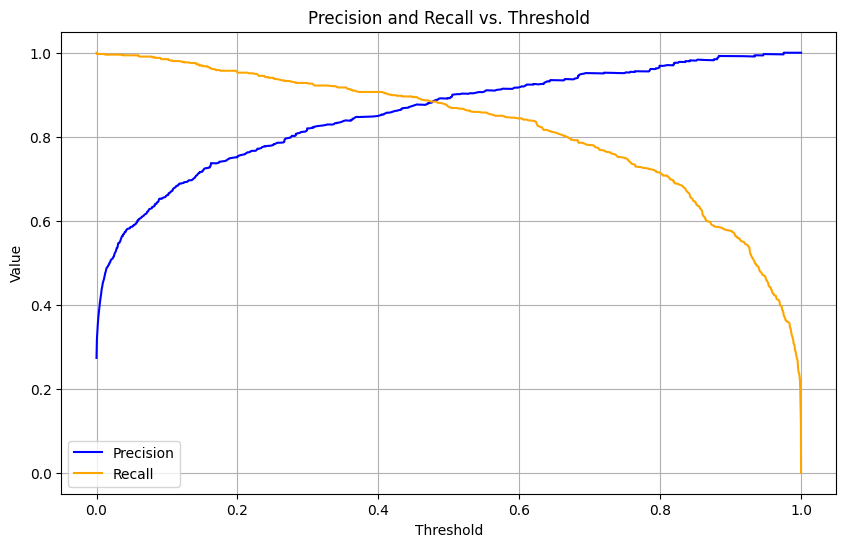

0.47661029341251543

In [25]:
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

intersect_threshold = thresholds[np.argmin(np.abs(precision[:-1] - recall[:-1]))]
intersect_threshold



In [27]:
for threshold in np.linspace(0, 1, 101):
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    try:
        precision = tp/(tp + fp)
    except:
        precision = 0
        
    try:
        recall = tp/(tp + fn)
    except:
        recall = 0
        
    f1_score = 1/(((1/precision) + (1/recall))/2)
    
    print(threshold, f1_score)

0.0 0.43068817912413565
0.01 0.6281310211946051
0.02 0.6714801444043321
0.03 0.7003765465303926
0.04 0.7274762171236708
0.05 0.7373794668179241
0.06 0.7508690614136733
0.07 0.7605633802816901
0.08 0.7729988052568696
0.09 0.7863664029214851
0.1 0.7911547911547911
0.11 0.8022528160200251
0.12 0.8085912823752368
0.13 0.8129770992366412
0.14 0.8184733803720334
0.15 0.8244473342002601
0.16 0.8291721419185283
0.17 0.8337765957446809
0.18 0.8363393453573814
0.19 0.8413978494623655
0.2 0.8418918918918918
0.21 0.8447457627118644
0.22 0.8491467576791809
0.23 0.8494845360824742
0.24 0.8525951557093425
0.25 0.8529819694868238
0.26 0.853948287910552
0.27 0.8597603946441156
0.28 0.8611898016997166
0.29 0.8659058487874465
0.3 0.870064608758076
0.31 0.8707581227436825
0.32 0.8720173535791758
0.33 0.872463768115942
0.34 0.8735465116279071
0.35000000000000003 0.8759124087591241
0.36 0.8740849194729136
0.37 0.8759231905465288
0.38 0.8765705838876572
0.39 0.8765705838876572
0.4 0.8785185185185185
0.410000

/tmp/ipykernel_32/2228324442.py:16: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp + fp)
/tmp/ipykernel_32/2228324442.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  f1_score = 1/(((1/precision) + (1/recall))/2)


In [33]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_index, val_index in kf.split(df_full_train):
    
    # Split the data
    df_train = df_full_train.iloc[train_index]
    df_val = df_full_train.iloc[val_index]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    df_train = df_train.drop(['above_average'], axis=1)
    df_val = df_val.drop(['above_average'], axis=1)

    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predict and evaluate the model
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    auc_scores.append(auc)

# Calculate the standard deviation of AUC scores
auc_std_dev = np.std(auc_scores)
print(f'The standard deviation of AUC scores: {round(auc_std_dev,3)}')

The standard deviation of AUC scores: 0.002


In [35]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


def prediction(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


for C in [0.01, 0.1, 0.5, 10]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    auc_scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        del df_train[target]
        del df_val[target]

        dv, model = train(df_train, y_train, C=C)
        y_pred = prediction(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(auc_scores), np.std(auc_scores)))

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.002
C=10 0.981 +- 0.003
